# Working (hopefully) example for Transfer function fit

## Toy model data generation

Considero una funzione di trasferimento $H(s)$ per un filtro passa basso, genero quindi inizialmente un set finito di dati con un errore, dati sperimentali ottenuti dal problema E1/R1


In [18]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import lmfit



from uncertainties import ufloat, unumpy

datafile = open('toymodel_bandpass.txt')

data = np.loadtxt(datafile)
data = data.transpose()


m_data = data[0]
m_data_err = data[1]
p_data = data[2] 
p_data_err = data[3]
f_data = data[4] 
f_data_err = data[5]

H_toymodel = m_data*np.exp(p_data*1j)

def tf_err(h0, eh0, phi, ephi):
    """Return complex valued error for transfer function model
    Parameters
    ----------
    h0 : `float`, `numpy.ndarray`
        data amplitude
    eh0 : `float`, `numpy.ndarray`
        data amplitude error
    phi : `float`, `numpy.ndarray`
        data phase
    ephi : `float`, `numpy.ndarray`
        data phase error
    Returns
    -------
    hat(H) : ``err(hat(H))``
    """
    return np.sqrt( ( np.exp(1j*phi)*eh0 )**2 + ( h0*1j*np.exp(1j*phi)*ephi )**2 )

def to_db(a):  # pylint: disable=invalid-name
    """Convert the input array into decibels
    Parameters
    ----------
    a : `float`, `numpy.ndarray`
        value or array of values to convert to decibels
    Returns
    -------
    dB : ``10 * numpy.log10(a)``
    Examples
    --------
    >>> to_db(1000)
    30.0
    """
    return 10 * np.log10(a)

def to_db_err(a, err_a):  # pylint: disable=invalid-name
    """Convert the input array into decibels
    Parameters
    ----------
    a : `float`, `numpy.ndarray`
        value or array of values to convert to decibels
    err_a : `float`, `numpy.ndarray`
        value or array of uncertainties to convert to decibels
    Returns
    -------
    err_dB : ``err(10 * numpy.log10(a))``
    """
    return 10 * err_a / ( a * np.log(10) )


err_H_toymodel = tf_err(m_data, m_data_err, p_data, p_data_err)

Text(0, 0.5, 'Phase (rad)')

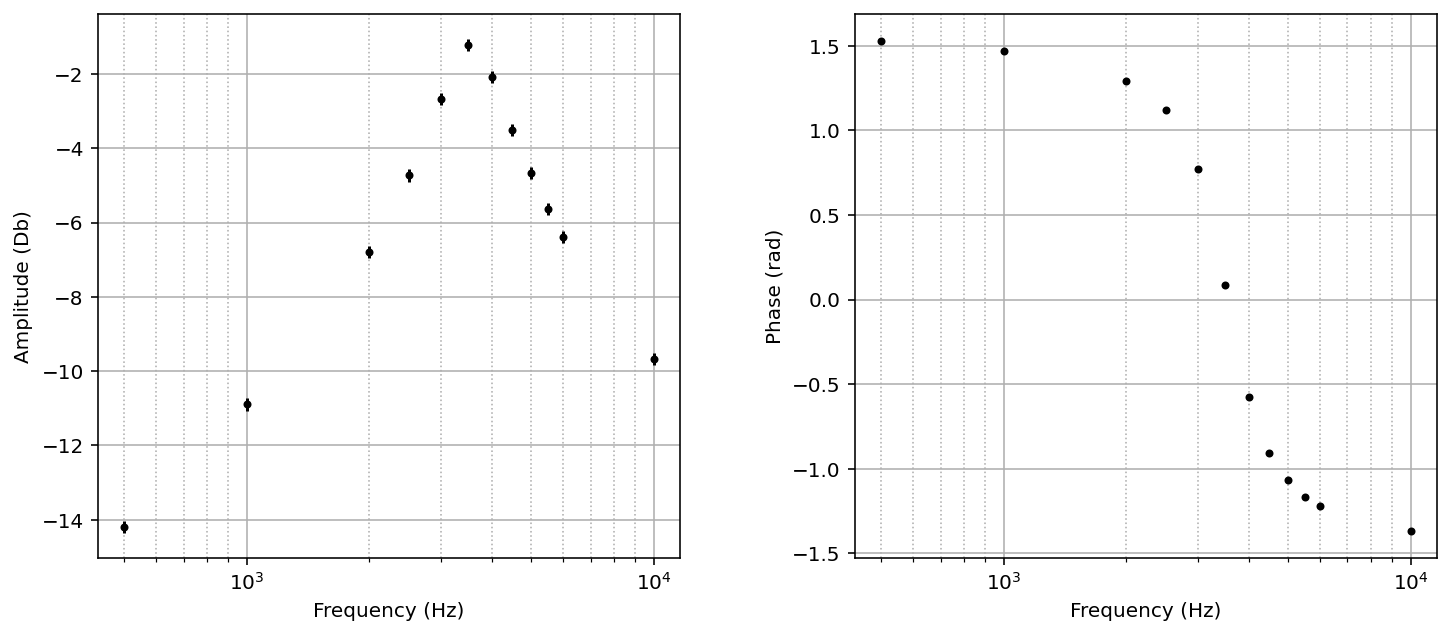

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.errorbar(f_data,to_db(np.abs(H_toymodel)), to_db_err(np.abs(H_toymodel),m_data_err),fmt='.',color='k')
ax2.errorbar(f_data,np.angle(H_toymodel),p_data_err,fmt='.',color='k')

plt.subplots_adjust(wspace=0.3)

ax1.semilogx()
#ax1.semilogy()
ax1.grid()
ax1.grid(which='minor',linestyle=':')
ax2.semilogx()
ax2.grid()
ax2.grid(which='minor',linestyle=':')

ax1.set_xlabel('Frequency (Hz)')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (Db)')
ax2.set_ylabel('Phase (rad)')


In [20]:

H = lambda s, f_0, Q, A: 1/(A+1j*Q*(s/f_0 - f_0/s))
s = np.logspace(np.log10(data[4].min()), np.log10(data[4].max()),1000)

class ActiveBandPass(lmfit.model.Model):
    __doc__ = 'Active Band-pass filter model' + lmfit.models.COMMON_INIT_DOC
    
    def __init__(self, *args, **kwargs):
        super().__init__(H, *args, **kwargs)
        
    
model = ActiveBandPass()


par = model.make_params(f_0=3e3, Q=1, A=1)

fit = model.fit(H_toymodel, params=par, s=f_data, verbose=True, weights=1/err_H_toymodel)
print(fit.fit_report())
fit.params.pretty_print()

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 24
    # variables        = 3
    chi-square         = 1.47113816
    reduced chi-square = 0.07005420
    Akaike info crit   = -61.0084193
    Bayesian info crit = -57.4742578
[[Variables]]
    f_0:  3552.12718 +/- 5.08080684 (0.14%) (init = 3000)
    Q:    3.75811099 +/- 0.01545079 (0.41%) (init = 1)
    A:    1.33887574 +/- 0.00935347 (0.70%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, A) = -0.213
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A       1.339     -inf      inf 0.009353     True     None     None
Q       3.758     -inf      inf  0.01545     True     None     None
f_0      3552     -inf      inf    5.081     True     None     None


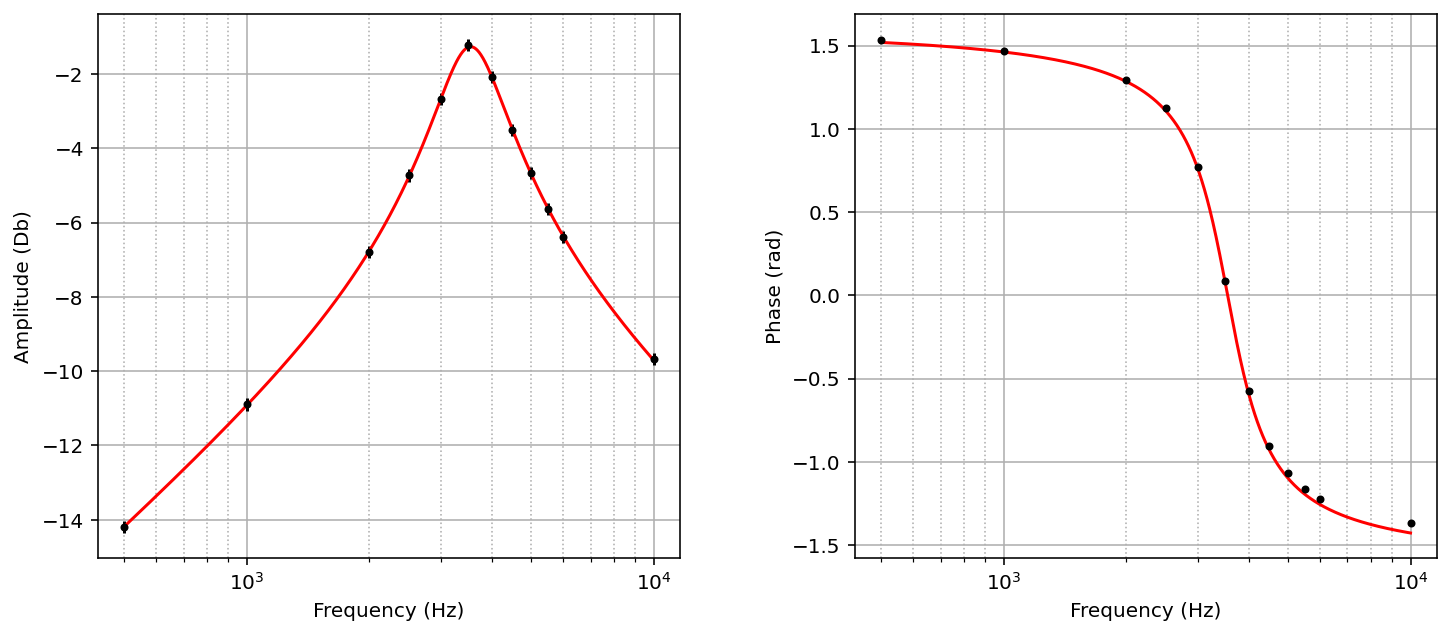

In [21]:
fit_model = model.eval(params=fit.params, s=s)

ax1.plot(s, to_db(np.abs(fit_model)), color='r')
ax2.plot(s, np.angle(fit_model), color='r')
fig

In [24]:
fig.savefig('toymodel_data_bandpass.pdf',bbox_inches='tight')

In [32]:
params = fit.params.valuesdict()
params

{'f_0': 3552.127184456752, 'Q': 3.758110990280504, 'A': 1.3388757442990888}

# Todo

[!!] Utilizzare _stderr_ (uncertainty) di ogni punto per pesare (`weights != None`) la funzione di LeastSquare per il fit, quindi trovare un modo di propagare l'errore dalla fase e apmpiezza alla funzione a variabili complesse)

[ ] classe: costruita per avere i filtri principali facili ma anche per poter utilizzare una funzione di trasferimento qualunque. 